In [1]:
from configs import cfg

cfg['input_dim'] = 301 # input dimension to LSTM
cfg['hidden_dim'] = 128 # hidden dimension for LSTM
cfg['output_dim'] = 1 # output dimension of the model
cfg['layers'] = 2 # number of layers of LSTM

cfg['dropout'] = 5e-3 # dropout rate between two layers of LSTM; useful only when layers > 1; between 0 and 1
cfg['bidirectional'] = True # True or False; True means using a bidirectional LSTM
cfg['batch_size'] = 120 # batch size of input
cfg['learning_rate'] = 1e-3 # learning rate to be used
cfg['L2_penalty'] = 1e-4 # weighting constant for L2 regularization term; this is a parameter when you define optimizer
cfg['epochs'] = 15 # number of epochs for which the model is trained
cfg['embed'] = False
cfg['score_range'] = 4
cfg['set_id'] = 5

In [2]:
import numpy as np
from preprocess import *
import pandas as pd

train_path = './essay_dataset/training_set_rel3.tsv'
training_data = load_training_set(train_path, cfg['set_id'])

glove_dict = load_dict('glove.840B.300d.pkl')

In [3]:
valid_path = './essay_dataset/valid_set.tsv'
valid_label_path = './essay_dataset/valid_sample_submission_2_column.csv'
valid_data = load_validation_set(valid_path, valid_label_path, cfg['set_id'])

In [4]:
training_data = process_scores(training_data, 'domain1_score')
valid_data = process_scores(valid_data, 'domain1_score')

In [5]:
from dataloader import *
from models import *
import time

model = LSTM_Score(cfg, True)
model = model.to(torch.device(cfg['device']))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['L2_penalty'])

train_indices = list(range(len(training_data)))
valid_indices = list(range(len(valid_data)))

print('ready')

ready


In [6]:
model.train()

LSTM_Score(
  (embed_linear): Linear(in_features=301, out_features=301, bias=True)
  (lstm): LSTM(301, 128, num_layers=2, batch_first=True, dropout=0.005, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
train_losses = []
val_losses = []
for epoch in range(cfg['epochs']):
    tloader = DataLoader(training_data, train_indices, cfg, glove_dict)
    vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
    
    count = 0
    avg_loss = 0
    while tloader.has_next():
        train, label, lengths = tloader.get_next()
        #print(train.size())
        #print(label.size())
        #print(lengths.size())
        model.zero_grad()
        
        y = model(train, lengths)      
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        loss.backward()
        optimizer.step()

        count += 1
        avg_loss += loss.item()
        if count % 2 == 0:
            print("count = %d, loss = %.5f" %(count, avg_loss / 2))
            save_model(model, 'models/'+'s' + str(cfg['set_id']) + '_ba' +str(cfg['batch_size']) +'e' +  str(epoch + 1) + 'b' + str(count) + '.pt')
            train_losses.append(avg_loss/2)
            avg_loss = 0
        del train, label, y, loss
    
    count = 0
    avg_loss = 0
    with torch.no_grad():
        while vloader.has_next():
            train, label, lengths = vloader.get_next()
            y = model(train, lengths)
            loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
            count += 1
            avg_loss += loss.item()
            del train, label, y, loss
    print('validation loss:', avg_loss / count)
    print('epoch finished:', epoch + 1)
    val_losses.append(avg_loss/count)
    

count = 2, loss = 1.22585
count = 4, loss = 1.08165
count = 6, loss = 0.58901
count = 8, loss = 0.37711
count = 10, loss = 0.32427
count = 12, loss = 0.32841
count = 14, loss = 0.32581
validation loss: 0.28874359130859373
epoch finished: 1
count = 2, loss = 0.31287
count = 4, loss = 0.30395
count = 6, loss = 0.30640
count = 8, loss = 0.28445
count = 10, loss = 0.27236
count = 12, loss = 0.24193
count = 14, loss = 0.23531
validation loss: 0.24393908977508544
epoch finished: 2
count = 2, loss = 0.25820
count = 4, loss = 0.23328
count = 6, loss = 0.20966
count = 8, loss = 0.25594
count = 10, loss = 0.28383
count = 12, loss = 0.27408
count = 14, loss = 0.26972
validation loss: 0.23419131338596344
epoch finished: 3
count = 2, loss = 0.26952
count = 4, loss = 0.29253
count = 6, loss = 0.22245
count = 8, loss = 0.25731
count = 10, loss = 0.22530
count = 12, loss = 0.18979
count = 14, loss = 0.26348
validation loss: 0.24342648983001708
epoch finished: 4
count = 2, loss = 0.24257
count = 4, los

In [8]:
np.save('val_loss_set5.npy', val_losses)
np.save('train_loss_set5.npy', train_losses)

In [21]:
model = load_model(LSTM_Score, './models/s4_ba120e9b14.pt', cfg)
valid_indices = list(range(len(valid_data)))

In [9]:
from evaluation import QWK_score

vloader = DataLoader(valid_data, valid_indices, cfg, glove_dict)
count = 0
avg_loss = 0
MAE = 0
targets = []
preds = []
with torch.no_grad():
    while vloader.has_next():
        train, label, lenghts = vloader.get_next()
        y = model(train, lenghts)
        #y = y.permute(0, 2, 1)
        #print(label - y)
        
        loss = criterion(y*cfg['score_range'], label*cfg['score_range'])
        
        pred = np.round(y.cpu().numpy() * cfg['score_range'])
        target = np.round(label.cpu().numpy() * cfg['score_range'])

        pred = pred.flatten().astype(int)
        target = target.flatten().astype(int)
        
        targets.append(target)
        preds.append(pred)
        
        #print(targets[0])
        #print(preds[0])
        
        count += 1
        avg_loss += loss.item()
        MAE += (y-label).abs().mean().item()
        
        del train, label, y, loss
        
print('validation MSE:', avg_loss / count)
print('validation MAE:', MAE / count)
print('QWK Score:', QWK_score(np.asarray(targets).flatten(), np.asarray(preds).flatten(), min_rating = 0, max_rating = cfg['score_range']))

validation MSE: 0.279956716299057
validation MAE: 0.1054874300956726
QWK Score: 0.7942216710302696


In [10]:
targets

[array([4, 3, 2, 4, 3, 3, 3, 2, 2, 4, 4, 2, 1, 3, 2, 2, 2, 3, 2, 2, 2, 4,
        2, 1, 2, 4, 4, 2, 1, 3, 3, 4, 2, 4, 3, 4, 3, 2, 3, 4, 4, 2, 3, 3,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 1, 3, 2, 2, 3, 3, 3, 4, 3, 1, 3, 4,
        2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 2, 2, 2, 1, 2, 3, 2, 3, 3, 3,
        2, 1, 3, 1, 2, 4, 3, 3, 3, 2, 3, 4, 2, 3, 1, 3, 3, 1, 2, 2, 4, 4,
        3, 3, 2, 3, 1, 3, 0, 1, 2, 3]),
 array([4, 4, 1, 3, 2, 2, 4, 2, 3, 3, 1, 3, 1, 3, 4, 4, 2, 2, 3, 3, 4, 3,
        3, 3, 4, 4, 3, 3, 2, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 4, 2, 3, 2, 2,
        4, 3, 4, 2, 2, 3, 2, 3, 3, 4, 1, 3, 2, 3, 2, 3, 2, 1, 1, 2, 1, 2,
        4, 3, 2, 1, 2, 1, 4, 2, 3, 3, 4, 4, 3, 2, 3, 3, 3, 3, 2, 2, 4, 2,
        1, 1, 3, 2, 2, 4, 4, 3, 2, 2, 3, 3, 2, 1, 4, 2, 2, 2, 3, 3, 4, 3,
        4, 2, 3, 2, 2, 2, 3, 2, 1, 2]),
 array([3, 3, 4, 3, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1, 4, 2,
        3, 4, 3, 4, 4, 1, 1, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 1, 4, 2, 0, 4,
        3, 4, 2, 2, 3, 2, 2, 3, 

In [11]:
preds

[array([4, 4, 1, 3, 3, 2, 3, 1, 2, 4, 3, 2, 1, 3, 2, 1, 1, 2, 2, 2, 3, 4,
        2, 1, 2, 4, 4, 2, 1, 3, 3, 3, 1, 4, 3, 4, 3, 2, 3, 4, 3, 2, 3, 2,
        1, 2, 3, 2, 1, 2, 1, 1, 3, 3, 1, 3, 2, 2, 3, 2, 3, 3, 3, 1, 3, 3,
        2, 1, 2, 3, 3, 3, 4, 3, 2, 3, 4, 3, 2, 2, 1, 1, 1, 3, 2, 3, 3, 3,
        2, 2, 3, 1, 1, 4, 3, 3, 3, 3, 3, 3, 2, 1, 1, 2, 3, 1, 2, 2, 3, 4,
        2, 3, 3, 3, 1, 3, 1, 1, 2, 3]),
 array([3, 4, 2, 2, 1, 3, 2, 2, 3, 3, 2, 3, 2, 4, 4, 3, 3, 2, 2, 3, 4, 3,
        4, 3, 3, 3, 4, 3, 1, 1, 3, 2, 2, 1, 2, 2, 1, 2, 1, 4, 2, 2, 2, 2,
        4, 3, 4, 3, 2, 3, 3, 1, 3, 3, 1, 3, 2, 3, 2, 3, 2, 2, 1, 2, 1, 1,
        4, 3, 2, 1, 1, 1, 4, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 4, 2, 1, 4, 1,
        1, 1, 3, 1, 2, 4, 4, 2, 1, 3, 2, 3, 1, 1, 4, 1, 2, 2, 3, 3, 4, 3,
        3, 2, 3, 2, 3, 2, 3, 1, 1, 2]),
 array([3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 1, 1, 2, 3, 1, 3, 0, 1, 1, 4, 2,
        3, 4, 3, 3, 4, 2, 1, 3, 3, 2, 4, 2, 2, 2, 3, 2, 3, 1, 3, 2, 1, 4,
        3, 4, 2, 3, 2, 2, 1, 3, 

In [12]:
train_losses

[1.225853681564331,
 1.0816507637500763,
 0.5890149176120758,
 0.37710803747177124,
 0.3242698013782501,
 0.3284074664115906,
 0.32580533623695374,
 0.31287090480327606,
 0.30394649505615234,
 0.30640266835689545,
 0.2844460681080818,
 0.2723584473133087,
 0.2419295683503151,
 0.23530960828065872,
 0.2582041472196579,
 0.23327849805355072,
 0.20966168493032455,
 0.2559366449713707,
 0.28383228182792664,
 0.2740766853094101,
 0.2697152718901634,
 0.26952266693115234,
 0.29252849519252777,
 0.22245149314403534,
 0.25731028616428375,
 0.2252955287694931,
 0.18978797644376755,
 0.2634832635521889,
 0.2425677701830864,
 0.21141638606786728,
 0.23406630009412766,
 0.22582221031188965,
 0.22456423938274384,
 0.2660878822207451,
 0.2280869260430336,
 0.2600165605545044,
 0.18999998271465302,
 0.25038696825504303,
 0.24655700474977493,
 0.2987850457429886,
 0.22976743429899216,
 0.1862700805068016,
 0.2315884754061699,
 0.23566090315580368,
 0.2157951518893242,
 0.22285596281290054,
 0.21122116

In [13]:
val_losses

[0.28874359130859373,
 0.24393908977508544,
 0.23419131338596344,
 0.24342648983001708,
 0.25284519195556643,
 0.2464669793844223,
 0.2394906163215637,
 0.2547000080347061,
 0.2715828508138657,
 0.24537601470947265,
 0.2557783335447311,
 0.2742406606674194,
 0.2370782434940338,
 0.2584267437458038,
 0.28292855620384216]

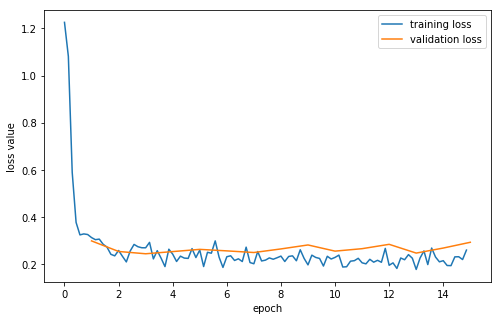

In [15]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(len(train_losses)) / (len(train_losses) // len(val_losses)),train_losses,label='training loss')
ax.plot(np.arange(1,len(val_losses)+1) ,np.array(val_losses) + 0.01,label='validation loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()